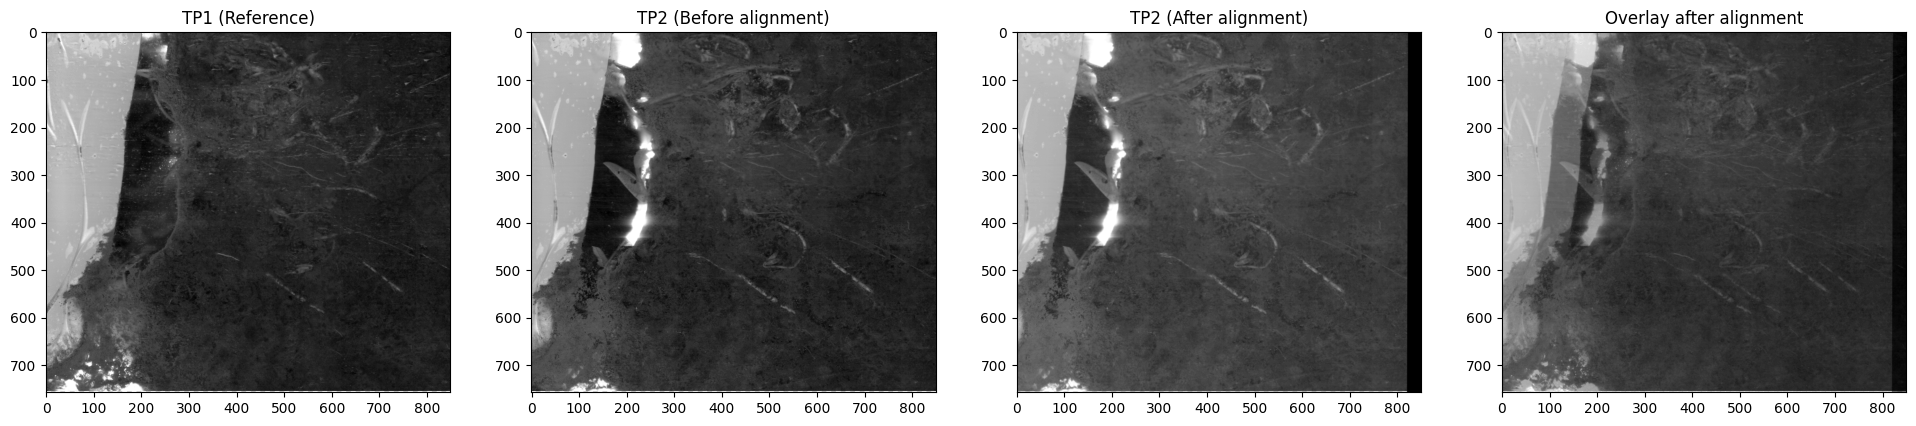

Estimated translation:  (-30.56310134825685, 0.07764047860649725)
Final affine transform:
 [[ 1.0013340e+00 -2.6729207e-03 -3.0573679e+01]
 [-3.6471625e-04  1.0028927e+00 -1.5253942e+00]]


True

In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# --- Load images ---
# im1 = cv.imread("slu_data/kura_201_001_2024-03-11_TP1.png", cv.IMREAD_GRAYSCALE)
# im2 = cv.imread("slu_data/kura_201_001_2024-03-26_TP2.png", cv.IMREAD_GRAYSCALE)
# im1 = cv.imread("slu_data/kura_201_001_2024-03-26_TP2.png", cv.IMREAD_GRAYSCALE)
# im2 = cv.imread("slu_data/kura_201_001_2024-04-09_TP3.png", cv.IMREAD_GRAYSCALE)
im1 = cv.imread("slu_data/slu_data_201/kura_201_001_2024-04-09_TP3.png", cv.IMREAD_GRAYSCALE)
im2 = cv.imread("slu_data/slu_data_201/kura_201_1_2024-04-22_TP4.png", cv.IMREAD_GRAYSCALE)

# --- Preprocessing ---
def preprocess(img):
    img = cv.GaussianBlur(img, (5, 5), 0)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    return img

I1, I2 = preprocess(im1), preprocess(im2)

# --- Initial translation (phase correlation) ---
win = cv.createHanningWindow(I1.shape, cv.CV_64F).T
shift, _ = cv.phaseCorrelate(np.float64(I1)*win, np.float64(I2)*win)
tx, ty = shift
M = np.array([[1, 0, tx], [0, 1, ty]], dtype=np.float32)

# --- Affine refinement with ECC (robust to intensity & small changes) ---
criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 200, 1e-6)
warp_mode = cv.MOTION_AFFINE

try:
    cc, M = cv.findTransformECC(I1, I2, M, warp_mode, criteria, None, 5)
except cv.error:
    print("ECC refinement failed; using phase correlation only.")

aligned = cv.warpAffine(im2, M, (im2.shape[1], im2.shape[0]), flags=cv.INTER_LINEAR)

# --- Overlay visualization ---
blend = cv.addWeighted(im1, 0.5, aligned, 0.5, 0)

plt.figure(figsize=(24,12))
plt.subplot(1,4,1); plt.imshow(im1, cmap='gray'); plt.title("TP1 (Reference)")
plt.subplot(1,4,2); plt.imshow(im2, cmap='gray'); plt.title("TP2 (Before alignment)")
plt.subplot(1,4,3); plt.imshow(aligned, cmap='gray'); plt.title("TP2 (After alignment)")
plt.subplot(1,4,4); plt.imshow(blend, cmap='gray'); plt.title("Overlay after alignment")
plt.show()

print("Estimated translation: ", (tx, ty))
print("Final affine transform:\n", M)

cv.imwrite("aligned_basic_phase-ecc.png", aligned)


Iter 0: metric=-0.56202
Iter 0: metric=-0.56344
Iter 0: metric=-0.56344
Iter 1: metric=-0.56834
Iter 1: metric=-0.56834
Iter 2: metric=-0.57553
Iter 2: metric=-0.57553
Iter 3: metric=-0.58109
Iter 3: metric=-0.58109
Iter 4: metric=-0.58680
Iter 4: metric=-0.58680
Iter 5: metric=-0.59511
Iter 5: metric=-0.59511
Iter 6: metric=-0.60296
Iter 6: metric=-0.60296
Iter 7: metric=-0.61367
Iter 7: metric=-0.61367
Iter 8: metric=-0.61867
Iter 8: metric=-0.61867
Iter 9: metric=-0.62555
Iter 9: metric=-0.62555
Iter 10: metric=-0.63756
Iter 10: metric=-0.63756
Iter 11: metric=-0.64247
Iter 11: metric=-0.64247
Iter 12: metric=-0.65106
Iter 12: metric=-0.65106
Iter 13: metric=-0.65731
Iter 13: metric=-0.65731
Iter 14: metric=-0.66061
Iter 14: metric=-0.66061
Iter 15: metric=-0.66654
Iter 15: metric=-0.66654
Iter 16: metric=-0.67031
Iter 16: metric=-0.67031
Iter 17: metric=-0.67505
Iter 17: metric=-0.67505
Iter 18: metric=-0.67987
Iter 18: metric=-0.67987
Iter 19: metric=-0.68735
Iter 19: metric=-0.68

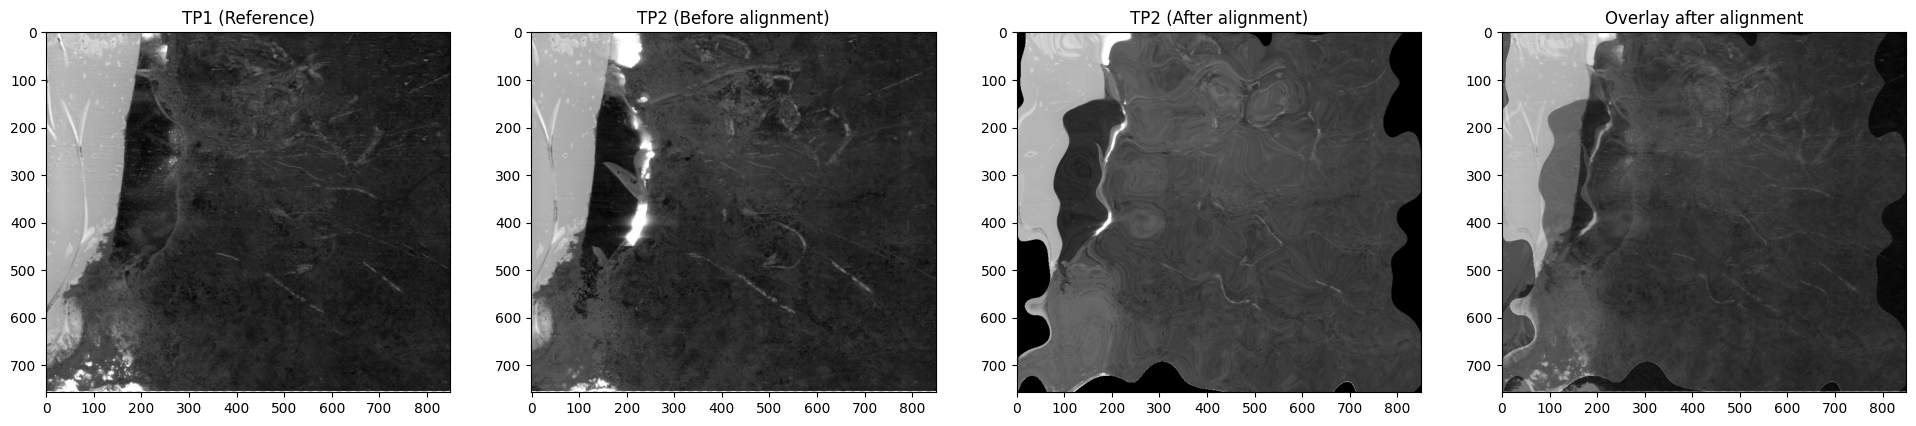

In [10]:
import SimpleITK as sitk

# --- Load grayscale images (uint8 or float, same size) ---
fixed = sitk.ReadImage("slu_data/slu_data_201/kura_201_001_2024-04-09_TP3.png", sitk.sitkFloat32)    # reference (earlier)
moving = sitk.ReadImage("aligned_basic_phase-ecc.png", sitk.sitkFloat32)  # affine-aligned later image

# --- Initial transform: affine (identity if already aligned) ---
initial_tx = sitk.CenteredTransformInitializer(
    fixed, moving,
    sitk.AffineTransform(fixed.GetDimension()),
    sitk.CenteredTransformInitializerFilter.GEOMETRY
)

# --- Setup registration method ---
registration = sitk.ImageRegistrationMethod()

# Similarity metric: Mattes mutual information (robust to intensity changes)
registration.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)

# You can mask out changing regions if you have a mask image
# registration.SetMetricFixedMask(fixed_mask)

# Use multi-resolution pyramids
registration.SetShrinkFactorsPerLevel([4, 2, 1])
registration.SetSmoothingSigmasPerLevel([2, 1, 0])
registration.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Optimizer: LBFGS is smooth and stable for small deformations
registration.SetOptimizerAsLBFGSB(
    gradientConvergenceTolerance=1e-5,
    numberOfIterations=100,
    maximumNumberOfCorrections=5,
    maximumNumberOfFunctionEvaluations=1000,
)

# --- Define the B-spline grid (controls how flexible the deformation is) ---
# Larger gridSpacing -> smoother, more global warp
grid_physical_spacing = [30.0, 30.0]  # mm or pixels depending on your spacing
image_physical_size = [sz*spc for sz, spc in zip(fixed.GetSize(), fixed.GetSpacing())]
mesh_size = [int(image_physical_size[i] / grid_physical_spacing[i] + 0.5)
             for i in range(fixed.GetDimension())]

initial_bspline_tx = sitk.BSplineTransformInitializer(fixed, mesh_size)

# Combine affine + B-spline
composite_tx = sitk.CompositeTransform(initial_tx)
composite_tx.AddTransform(initial_bspline_tx)

registration.SetInitialTransform(composite_tx, inPlace=False)

# Metric sampling (use a subset of pixels for speed)
registration.SetMetricSamplingStrategy(registration.RANDOM)
registration.SetMetricSamplingPercentage(0.2)

# Progress feedback
registration.AddCommand(sitk.sitkIterationEvent,
    lambda: print(f"Iter {registration.GetOptimizerIteration()}: "
                  f"metric={registration.GetMetricValue():.5f}"))

# --- Execute registration ---
final_tx = registration.Execute(fixed, moving)

print("Final metric:", registration.GetMetricValue())

# --- Apply the final transform ---
resampled = sitk.Resample(
    moving, fixed, final_tx,
    sitk.sitkLinear, 0.0, moving.GetPixelID()
)

sitk.WriteImage(fixed, "reference.tif")
sitk.WriteImage(resampled, "aligned_phase-ecc_bspline.tif")

# --- Overlay visualization ---
reference = cv.imread("reference.tif", cv.IMREAD_UNCHANGED)
aligned_bspline = cv.imread("aligned_phase-ecc_bspline.tif", cv.IMREAD_UNCHANGED)
blend_resampled = cv.addWeighted(reference, 0.5, aligned_bspline, 0.5, 0)

plt.figure(figsize=(24,12))
plt.subplot(1,4,1); plt.imshow(im1, cmap='gray'); plt.title("TP1 (Reference)")
plt.subplot(1,4,2); plt.imshow(im2, cmap='gray'); plt.title("TP2 (Before alignment)")
plt.subplot(1,4,3); plt.imshow(aligned_bspline, cmap='gray'); plt.title("TP2 (After alignment)")
plt.subplot(1,4,4); plt.imshow(blend_resampled, cmap='gray'); plt.title("Overlay after alignment")
plt.show()
